In [1]:
IDS_TO_DISCARD = [
        "636767001a6d9265ec01787e",
        "636767461a6d9265ec017d17",
        "6367667f1a6d9265ec01745c",
        "636766821a6d9265ec0174d2",
        "6367667f1a6d9265ec017458",
        "636766811a6d9265ec017499",
        "6367667c1a6d9265ec0173f7",
        "6367667d1a6d9265ec0173ff",
        "6367667c1a6d9265ec0173fb",
        "636766811a6d9265ec017496",
        "636766801a6d9265ec017482",
        "636766801a6d9265ec017477",
        "636767781a6d9265ec01823d",
        "636767791a6d9265ec018257",
        "636767781a6d9265ec01823e",
        "636767de1a6d9265ec01871e",
        "636767de1a6d9265ec018706",
        "636767dc1a6d9265ec0186c6",
        "636767de1a6d9265ec018726",
        "636767e11a6d9265ec018790",
    
        "636766fe1a6d9265ec017833",
        "636767001a6d9265ec01787f",
        "636767071a6d9265ec017962",
        "636767641a6d9265ec01817d",
        "636767531a6d9265ec017efb",
        "6367675a1a6d9265ec018010",
        "636767601a6d9265ec0180fd",
        "636767641a6d9265ec018190",
        "636767841a6d9265ec0183ff",
    
        "636766f81a6d9265ec017748",
        "636766ef1a6d9265ec01761a",
        "636766fe1a6d9265ec017823",
        "636766f81a6d9265ec01774b",
        "636767611a6d9265ec018106",
        "636766821a6d9265ec0174b3",
        "636766851a6d9265ec017515",
        "636767691a6d9265ec0181ae",
        "636767791a6d9265ec018263",
        "636767781a6d9265ec018238",
        "636767781a6d9265ec018242",
        "6367677e1a6d9265ec018314",
        "636767841a6d9265ec0183f2",
        "636766a81a6d9265ec017596",
        "636766a81a6d9265ec01757b",
        "636767ab1a6d9265ec01867b",
        "636767aa1a6d9265ec01865a"
    ]

In [2]:
MODEL_NAMES = [
    'DeepSeek Coder 1.3B',
    'DeepSeek Coder 6.7B',
    'DeepSeek Coder 33B',
    'CodeLlama 7B',
    'CodeLlama 13B',
    'CodeLlama 34B',
    'GPT-3.5-turbo',
    'GPT-4-turbo'
]

MODEL_NAMES_SHORT = [
    'DSC 1.3B',
    'DSC 6.7B',
    'DSC 33B',
    'CL 7B',
    'CL 13B',
    'CL 34B',
    'GPT 3.5',
    'GPT 4'
]

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [4]:
instances = json.load(open('/Users/giuseppecrupi/Desktop/projects/1_llms_collaboration/data/input/CoderEval4Java.json'))['RECORDS']

# Scale

In [5]:
# import data and add "level" field
scale = pd.read_csv('../../2_llms_as_judge/results/icse25/overall/cg_judgement_java_scale_human.csv')
level = []
for tid in scale.target_id:
    l = [i['level'] for i in instances if i['_id'] == str(tid)][0]
    level.append(l)
scale['level'] = level
# scale = scale.loc[(scale.level == 'self_contained') | (scale.level == 'slib_runnable')]

In [6]:
print(f'Shape before cleaning : {scale.shape}.')
scale.dropna(subset = 'generated_code', inplace = True) # exlude all the cases in which the model in charge of the code generation was not able to produce a valid prediction
scale = scale.loc[~scale.target_id.isin(IDS_TO_DISCARD)] # exlude all the ids after the test suite cleaning
print(f'Shape after cleaning : {scale.shape}.')
print()
for col in [c for c in scale.columns if '_rating' in c]:
    scale[col] = scale[col].fillna('-')
    scale[col] = scale[col].apply(lambda x : int(x) if x != '-' else x)
    print('{0} was not able to generate a valid judgement {1} times out of {2}'.format(col.split('_rating')[0], scale.loc[scale[col] == '-'].shape[0], scale.shape[0]))

Shape before cleaning : (2024, 21).
Shape after cleaning : (1615, 21).

deepseek-coder-1.3b-instruct was not able to generate a valid judgement 39 times out of 1615
deepseek-coder-6.7b-instruct was not able to generate a valid judgement 2 times out of 1615
deepseek-coder-33b-instruct was not able to generate a valid judgement 2 times out of 1615
CodeLlama-7b-Instruct-hf was not able to generate a valid judgement 1 times out of 1615
CodeLlama-13b-Instruct-hf was not able to generate a valid judgement 0 times out of 1615
CodeLlama-34b-Instruct-hf was not able to generate a valid judgement 2 times out of 1615
gpt-3.5-turbo was not able to generate a valid judgement 0 times out of 1615
gpt-4-turbo was not able to generate a valid judgement 0 times out of 1615


In [7]:
scale_sns = pd.DataFrame()
for col in [c for c in scale.columns if '_rating' in c]:
    cols_to_take = ['target_id', 'generated_by', 'generated_code', 'is_pass'] + [col]
    to_concat = scale[cols_to_take]
    to_concat.rename(columns = {col : 'rating'}, inplace = True)
    to_concat['model'] = col.split('_rating')[0]
    to_concat = to_concat.loc[to_concat.rating != '-'] # exlude all the cases in which the judge model was not able to procude a valid judgement
    scale_sns = pd.concat([scale_sns, to_concat])

scale_sns['model'] = scale_sns['model'].replace('deepseek-coder-1.3b-instruct', 'DeepSeek Coder 1.3B')
scale_sns['model'] = scale_sns['model'].replace('deepseek-coder-6.7b-instruct', 'DeepSeek Coder 6.7B')
scale_sns['model'] = scale_sns['model'].replace('deepseek-coder-33b-instruct', 'DeepSeek Coder 33B')
# scale_sns['model'] = scale_sns['model'].replace('DeepSeek-Coder-V2-Lite-Instruct', 'DeepSeek Coder V2 Lite')
scale_sns['model'] = scale_sns['model'].replace('CodeLlama-7b-Instruct-hf', 'CodeLlama 7B')
scale_sns['model'] = scale_sns['model'].replace('CodeLlama-13b-Instruct-hf', 'CodeLlama 13B')
scale_sns['model'] = scale_sns['model'].replace('CodeLlama-34b-Instruct-hf', 'CodeLlama 34B')
scale_sns['model'] = scale_sns['model'].replace('gpt-3.5-turbo', 'GPT-3.5-turbo')
scale_sns['model'] = scale_sns['model'].replace('gpt-4-turbo', 'GPT-4-turbo')
scale_sns.rename(columns = {'is_pass' : 'pass'}, inplace = True)

/var/folders/4l/l9t6kyb179q8hhckb219jw200000gn/T/ipykernel_51455/78437415.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_concat.rename(columns = {col : 'rating'}, inplace = True)
/var/folders/4l/l9t6kyb179q8hhckb219jw200000gn/T/ipykernel_51455/78437415.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_concat['model'] = col.split('_rating')[0]
/var/folders/4l/l9t6kyb179q8hhckb219jw200000gn/T/ipykernel_51455/78437415.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

In [8]:
print(scale_sns.shape)
# Calculate number of obs per group & median to position labels
medians = scale_sns.groupby(['model', 'pass'], as_index = False).agg({'rating' : list})
medians['count'] = medians['rating'].apply(lambda x : len(x))
medians['median'] = medians['rating'].apply(lambda x : np.median(x))
medians['pass'] = medians['pass'].replace(0, -1)
medians.index = [8, 9, 10, 11, 6, 7, 0, 1, 4, 5, 2, 3, 12, 13, 14, 15]
medians.sort_index(inplace = True)
medians['model_number'] = [0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7]
medians

(12874, 6)


,model,pass,rating,count,median,model_number
0,DeepSeek Coder 1.3B,-1,"[4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, ...",931,4.0,0
1,DeepSeek Coder 1.3B,1,"[4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, ...",645,4.0,0
2,DeepSeek Coder 6.7B,-1,"[5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 4, 5, ...",956,5.0,1
3,DeepSeek Coder 6.7B,1,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",657,5.0,1
4,DeepSeek Coder 33B,-1,"[5, 5, 5, 5, 5, 4, 5, 1, 5, 4, 5, 4, 5, 3, 5, ...",957,5.0,2
5,DeepSeek Coder 33B,1,"[5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, ...",656,5.0,2
6,CodeLlama 7B,-1,"[5, 4, 5, 4, 5, 4, 4, 5, 4, 5, 5, 5, 4, 4, 5, ...",958,4.0,3
7,CodeLlama 7B,1,"[5, 5, 5, 4, 4, 4, 5, 4, 5, 4, 5, 4, 5, 5, 5, ...",656,4.0,3
8,CodeLlama 13B,-1,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, ...",958,4.0,4
9,CodeLlama 13B,1,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",657,4.0,4


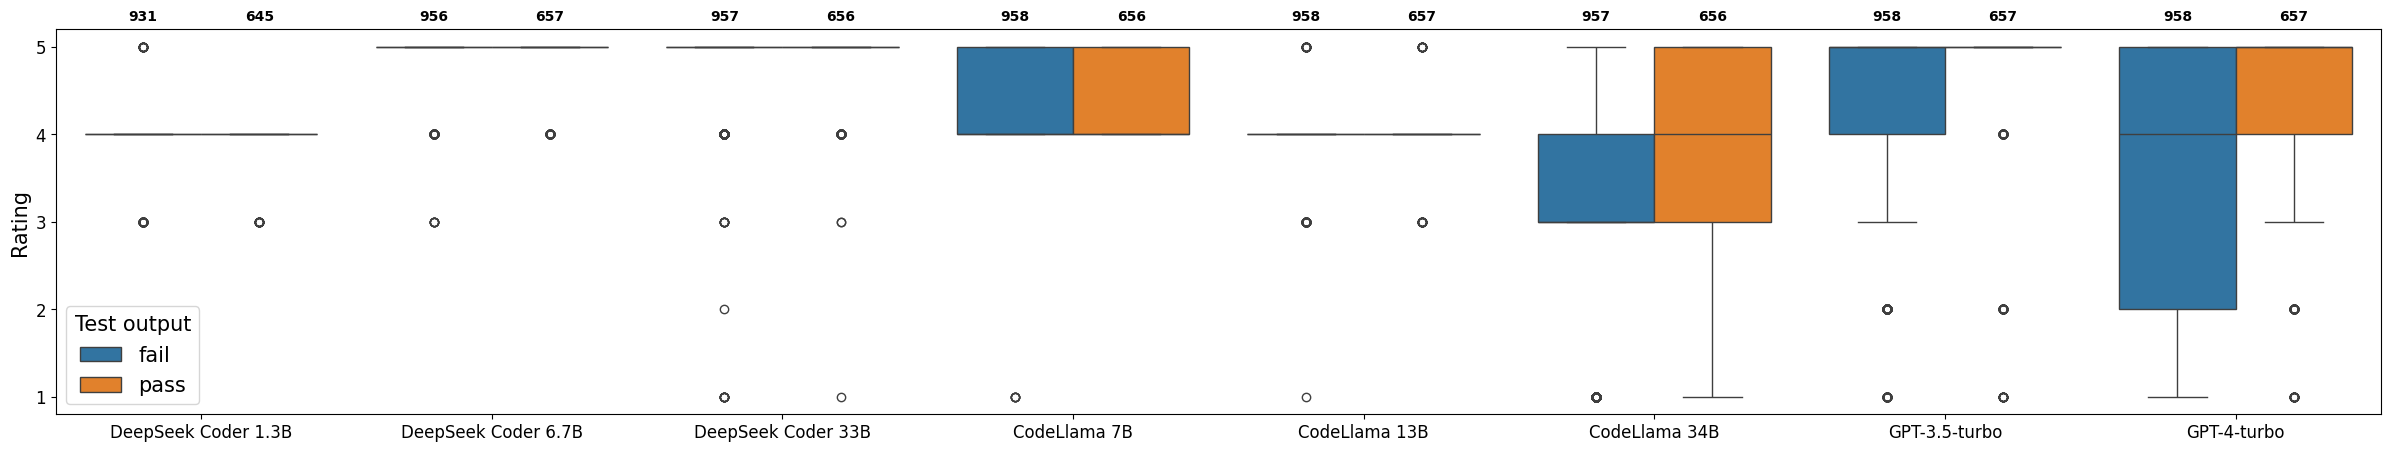

In [9]:
scale_sns['pass'] = scale_sns['pass'].replace(1, 'pass')
scale_sns['pass'] = scale_sns['pass'].replace(0, 'fail')

plt.figure(figsize=(30,5))
ax = sns.boxplot(data = scale_sns, y = 'rating', x = 'model', hue = 'pass', hue_order = ['fail', 'pass'])
plt.xticks(rotation = 0, fontsize = 12)
plt.yticks([1, 2, 3, 4, 5], fontsize = 12)
plt.xlabel('', fontsize = 15)
plt.ylabel('Rating', fontsize = 15)
plt.legend(fontsize = 15, title = 'Test output', title_fontsize = 15)


for i in range(medians.shape[0]):
    ax.text(
            medians['model_number'].iloc[i] + medians['pass'].iloc[i] * .2,
            5.3,
            # medians['median'].iloc[i] + 0.06,
            medians['count'].iloc[i],
            horizontalalignment = 'center',
            size = 10,
            color = 'black',
            weight = 'semibold')

# Boolean

In [5]:
from sklearn import metrics

In [6]:
# import data and add "level" field
boolean = pd.read_csv('../../2_llms_as_judge/results/icse25/overall/cg_judgement_java_boolean_human.csv')
level = []
for tid in boolean.target_id:
    l = [i['level'] for i in instances if i['_id'] == str(tid)][0]
    level.append(l)
boolean['level'] = level
# boolean = boolean.loc[(boolean.level == 'self_contained') | (boolean.level == 'slib_runnable')]

In [ ]:
# # to visualize the total number of judgments for cg (splitting summaries generated by LLMs or written by humans)
# boolean.dropna(subset = 'generated_code', inplace = True) # exlude all the cases in which the model in charge of the code generation was not able to produce a valid prediction
# boolean = boolean.loc[~boolean.target_id.isin(IDS_TO_DISCARD)] # exlude all the ids after the test suite cleaning

# boolean['is_human_generated'] = boolean['generated_by'].apply(lambda x : x if x == 'human_written' else 'not_human')
# g = boolean.groupby('is_human_generated', as_index=False).agg({
#     'deepseek-coder-1.3b-instruct_rating' : list,
#     'deepseek-coder-6.7b-instruct_rating' : list,
#     'deepseek-coder-33b-instruct_rating' : list,
#     'CodeLlama-7b-Instruct-hf_rating' : list,
#     'CodeLlama-13b-Instruct-hf_rating' : list,
#     'CodeLlama-34b-Instruct-hf_rating' : list,
#     'gpt-3.5-turbo_rating' : list,
#     'gpt-4-turbo_rating' : list
#     })

# H = 0
# NH = 0
# for col in [x for x in g.columns if '_rating' in x]:
#     h = [x for x in g[col].iloc[0] if x != '-']
#     nh = [x for x in g[col].iloc[1] if x != '-']
#     H+=len(h)
#     NH+=len(nh)
#     print(f'{col} : {len(h)} human')
#     print(f'{col} : {len(nh)} not human')
#     print(1615 - len(h) - len(nh))
# print(H, NH)

deepseek-coder-1.3b-instruct_rating : 104 human
deepseek-coder-1.3b-instruct_rating : 824 not human
687
deepseek-coder-6.7b-instruct_rating : 178 human
deepseek-coder-6.7b-instruct_rating : 1415 not human
22
deepseek-coder-33b-instruct_rating : 183 human
deepseek-coder-33b-instruct_rating : 1428 not human
4
CodeLlama-7b-Instruct-hf_rating : 183 human
CodeLlama-7b-Instruct-hf_rating : 1431 not human
1
CodeLlama-13b-Instruct-hf_rating : 181 human
CodeLlama-13b-Instruct-hf_rating : 1431 not human
3
CodeLlama-34b-Instruct-hf_rating : 183 human
CodeLlama-34b-Instruct-hf_rating : 1430 not human
2
gpt-3.5-turbo_rating : 184 human
gpt-3.5-turbo_rating : 1431 not human
0
gpt-4-turbo_rating : 171 human
gpt-4-turbo_rating : 1417 not human
27
1367 10807


In [7]:
print(f'Shape before cleaning : {boolean.shape}.')
boolean.dropna(subset = 'generated_code', inplace = True) # exlude all the cases in which the model in charge of the code generation was not able to produce a valid prediction
boolean = boolean.loc[~boolean.target_id.isin(IDS_TO_DISCARD)] # exlude all the ids after the test suite cleaning
print(f'Shape after cleaning : {boolean.shape}.')
print()

for col in [c for c in boolean.columns if '_rating' in c]:
    boolean[col] = boolean[col].apply(lambda x : int(x) if x != '-' else x)
    print('{0} was not able to generate a valid judgement {1} times out of {2}'.format(col.split('_rating')[0], boolean.loc[boolean[col] == '-'].shape[0], boolean.shape[0]))

print()
for col in [c for c in boolean.columns if '_rating' in c]:
    bool_temp = boolean.loc[(boolean.generated_by == 'human_written') & (boolean[col] != '-')]
    judge = col.split('_rating')[0]
    print('{0} predicts "correct" for target {1} out of {2} ({3:.2f}%) (fails to give a valid judgement in {4} cases).'.format(judge, bool_temp[col].sum(), bool_temp.shape[0], bool_temp[col].sum()/bool_temp.shape[0]*100, 230-len(IDS_TO_DISCARD)-bool_temp.shape[0]))

Shape before cleaning : (2024, 21).
Shape after cleaning : (1615, 21).

deepseek-coder-1.3b-instruct was not able to generate a valid judgement 687 times out of 1615
deepseek-coder-6.7b-instruct was not able to generate a valid judgement 22 times out of 1615
deepseek-coder-33b-instruct was not able to generate a valid judgement 4 times out of 1615
CodeLlama-7b-Instruct-hf was not able to generate a valid judgement 1 times out of 1615
CodeLlama-13b-Instruct-hf was not able to generate a valid judgement 3 times out of 1615
CodeLlama-34b-Instruct-hf was not able to generate a valid judgement 2 times out of 1615
gpt-3.5-turbo was not able to generate a valid judgement 0 times out of 1615
gpt-4-turbo was not able to generate a valid judgement 27 times out of 1615

deepseek-coder-1.3b-instruct predicts "correct" for target 14 out of 104 (13.46%) (fails to give a valid judgement in 80 cases).
deepseek-coder-6.7b-instruct predicts "correct" for target 177 out of 178 (99.44%) (fails to give a v

In [8]:
# bool_sns = pd.DataFrame()
# for col in [c for c in boolean.columns if '_rating' in c]:
#     cols_to_take = ['target_id', 'generated_by', 'generated_code', 'is_pass'] + [col]
#     to_concat = boolean[cols_to_take]
#     to_concat.rename(columns = {col : 'rating'}, inplace = True)
#     to_concat['model'] = col.split('_rating')[0]
#     # to_concat = to_concat.loc[to_concat.rating != '-'] # exlude all the cases in which the judge model was not able to procude a valid judgement
#     bool_sns = pd.concat([bool_sns, to_concat])
# bool_sns.loc[(scale_sns.generated_by == 'human_written') & (bool_sns.rating == '-')].shape, bool_sns.shape

/var/folders/4l/l9t6kyb179q8hhckb219jw200000gn/T/ipykernel_5273/259829377.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boolean_temp[f'{model}_rating'] = boolean_temp[f'{model}_rating'].apply(lambda x : int(x))
/var/folders/4l/l9t6kyb179q8hhckb219jw200000gn/T/ipykernel_5273/259829377.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boolean_temp[f'{model}_rating'] = boolean_temp[f'{model}_rating'].apply(lambda x : int(x))
/var/folders/4l/l9t6kyb179q8hhckb219jw200000gn/T/ipykernel_5273/259829377.py

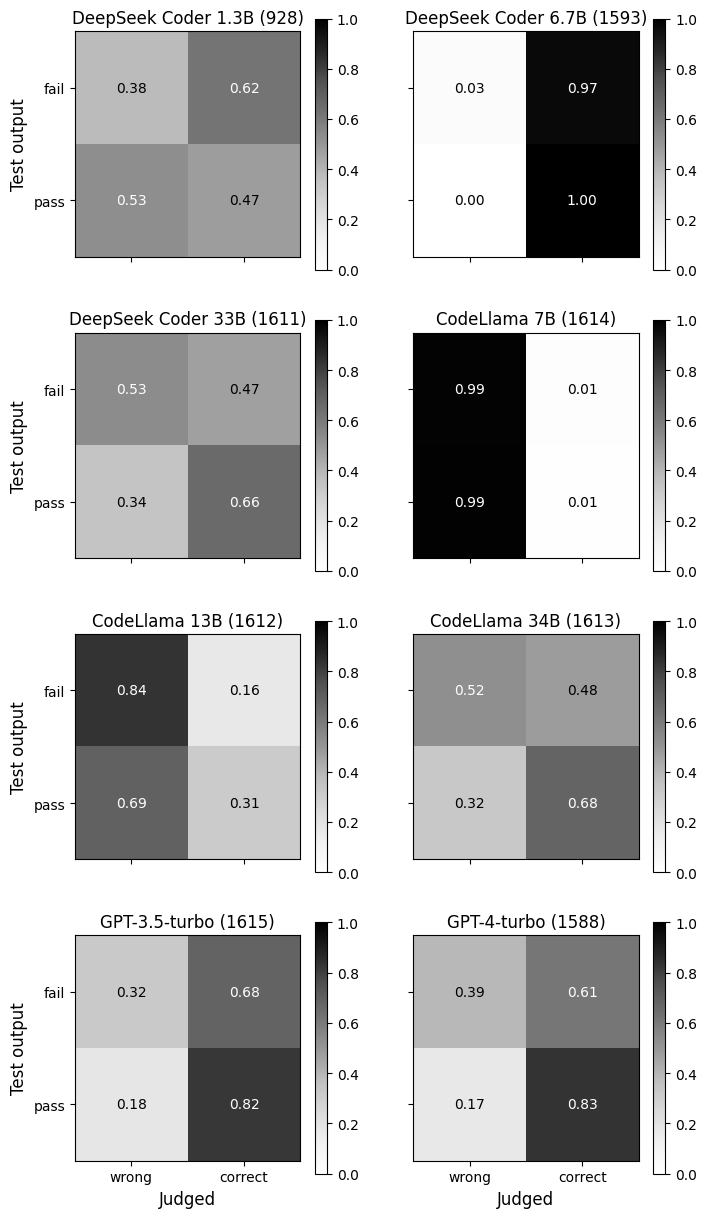

In [9]:
num_rows, num_cols = 4, 2
fig, axs = plt.subplots(num_rows, num_cols, sharex = True, sharey = True, figsize = (8,15))
models = ['deepseek-coder-1.3b-instruct', 'deepseek-coder-6.7b-instruct', 'deepseek-coder-33b-instruct', 'CodeLlama-7b-Instruct-hf', 'CodeLlama-13b-Instruct-hf', 'CodeLlama-34b-Instruct-hf', 'gpt-3.5-turbo', 'gpt-4-turbo']
model_label = MODEL_NAMES

for i in range(num_rows):
    for j in range(num_cols):
        model = models[num_cols * i + j]
        boolean_temp = boolean.loc[boolean[f'{model}_rating'] != '-']
        boolean_temp[f'{model}_rating'] = boolean_temp[f'{model}_rating'].apply(lambda x : int(x))
        actual = boolean_temp.is_pass
        predicted = boolean_temp[f'{model}_rating']
        confusion_matrix = metrics.confusion_matrix(actual, predicted, normalize = 'true')
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
        cm_display.plot(cmap = 'Greys', ax = axs[i,j], values_format = '.2f')
        cm_display.im_.set_clim(0, 1)
        axs[i,j].set_title(f'{model_label[num_cols * i + j]} ({boolean_temp.shape[0]})')
        axs[i,j].set_xlabel('') if i != num_rows - 1 else axs[i,j].set_xlabel('Judged', fontsize = 12)
        axs[i,j].set_ylabel('') if j != 0 else axs[i,j].set_ylabel('Test output', fontsize = 12)

        # if j == 0:
        axs[i,j].set_yticks(ticks = [0, 1], labels = ['fail', 'pass'])
        axs[i,j].set_xticks(ticks = [0, 1], labels = ['wrong', 'correct'])

plt.show()

/var/folders/4l/l9t6kyb179q8hhckb219jw200000gn/T/ipykernel_6974/3844788466.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boolean_temp[f'{model}_rating'] = boolean_temp[f'{model}_rating'].apply(lambda x : int(x))


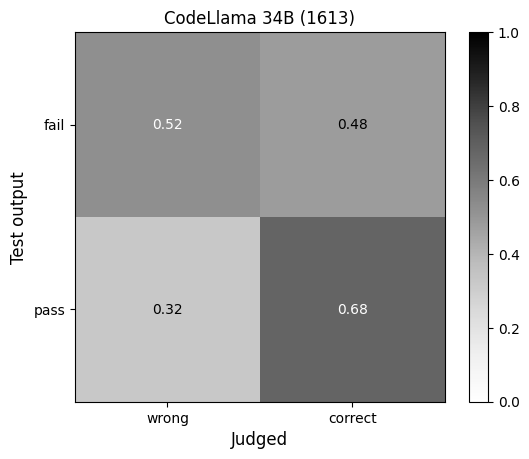

In [28]:
model_idx = 5
model = models[model_idx]
boolean_temp = boolean.loc[boolean[f'{model}_rating'] != '-']
boolean_temp[f'{model}_rating'] = boolean_temp[f'{model}_rating'].apply(lambda x : int(x))
actual = boolean_temp.is_pass
predicted = boolean_temp[f'{model}_rating']
confusion_matrix = metrics.confusion_matrix(actual, predicted, normalize = 'true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot(cmap = 'Greys', values_format = '.2f')
cm_display.im_.set_clim(0, 1)
plt.title(f'{model_label[model_idx]} ({boolean_temp.shape[0]})')
plt.xlabel('Judged', fontsize = 12)
plt.ylabel('Test output', fontsize = 12)

plt.yticks(ticks = [0, 1], labels = ['fail', 'pass'])
plt.xticks(ticks = [0, 1], labels = ['wrong', 'correct'])
plt.savefig('/Users/giuseppecrupi/Desktop/demo.png', transparent = True)
plt.show()

# Spearman correlation & Kappa score
Evaluate the Spearman correlation coefficient between the {0, 1} series of the is_pass field and the series of ratings given by the LLMs.

In [10]:
from scipy.stats import spearmanr
from sklearn.metrics import cohen_kappa_score

In [11]:
# scale spearman correlation
scale_spear_corr = []
for col in [c for c in scale.columns if '_rating' in c]:
    scale_spear = scale.loc[scale[col] != '-']
    corr = spearmanr(scale_spear['is_pass'], scale_spear[col]).correlation
    scale_spear_corr.append('{0:.2f}'.format(corr, scale_spear.shape[0]))
    print('{} : {:.2f} (number of judgments {})'.format(col.split('_')[0], corr, scale_spear.shape[0]))
    # print(col, ':', corr, scale_spear.shape)

NameError: name 'scale' is not defined

In [12]:
# boolean spearman correlation
bool_spear_corr = []
for col in [c for c in boolean.columns if '_rating' in c]:
    boolean_spear = boolean.loc[boolean[col] != '-']
    corr = spearmanr(boolean_spear['is_pass'], boolean_spear[col]).correlation
    bool_spear_corr.append('{0:.2f}'.format(corr, boolean_spear.shape[0]))
    print(col, ':', corr, boolean_spear.shape)

deepseek-coder-1.3b-instruct_rating : -0.14010436006157315 (928, 21)
deepseek-coder-6.7b-instruct_rating : 0.11376982514562684 (1593, 21)
deepseek-coder-33b-instruct_rating : 0.18886152519712274 (1611, 21)
CodeLlama-7b-Instruct-hf_rating : -0.020144336965902458 (1614, 21)
CodeLlama-13b-Instruct-hf_rating : 0.17134233061182821 (1612, 21)
CodeLlama-34b-Instruct-hf_rating : 0.1966815515864931 (1613, 21)
gpt-3.5-turbo_rating : 0.15686060962228504 (1615, 21)
gpt-4-turbo_rating : 0.2363266530672399 (1588, 21)


In [13]:
# boolean kappa score
bool_kappa = []
for col in [c for c in boolean.columns if '_rating' in c]:
    boolean_kappa = boolean.loc[boolean[col] != '-']
    score = cohen_kappa_score(boolean_kappa['is_pass'], boolean_kappa[col].astype(int))
    bool_kappa.append('{0:.2f}'.format(score, boolean_kappa.shape[0]))
    print(col, ':', score, boolean_kappa.shape)

deepseek-coder-1.3b-instruct_rating : -0.13062669465188126 (928, 21)
deepseek-coder-6.7b-instruct_rating : 0.027484910238789073 (1593, 21)
deepseek-coder-33b-instruct_rating : 0.1817884113033683 (1611, 21)
CodeLlama-7b-Instruct-hf_rating : -0.005223001497385749 (1614, 21)
CodeLlama-13b-Instruct-hf_rating : 0.15660245087595104 (1612, 21)
CodeLlama-34b-Instruct-hf_rating : 0.18757780597670193 (1613, 21)
gpt-3.5-turbo_rating : 0.12435182811932288 (1615, 21)
gpt-4-turbo_rating : 0.19691473260819625 (1588, 21)


In [14]:
for col in [c for c in boolean.columns if '_rating' in c]:
    boolean_temp = boolean.loc[boolean[col] != '-']
    boolean_temp[['is_pass', col]].to_csv(f'/Users/giuseppecrupi/Desktop/{col}_kripp.csv', index = False, header = None)

In [15]:
df = pd.DataFrame({
    'bool' : bool_spear_corr,
    'scale' : scale_spear_corr,
}).T

df.columns = MODEL_NAMES
# df.columns = ['ds-1.3b', 'ds-6.7b', 'ds-33b', 'cl-7b', 'cl-13b', 'cl-34b', 'gpt-3.5-turbo', 'gpt-4-turbo']
print(df.to_latex())

ValueError: All arrays must be of the same length

In [16]:
df = pd.DataFrame({
    'bool' : bool_kappa
}).T

df.columns = MODEL_NAMES
# df.columns = ['ds-1.3b', 'ds-6.7b', 'ds-33b', 'cl-7b', 'cl-13b', 'cl-34b', 'gpt-3.5-turbo', 'gpt-4-turbo']
print(df.to_latex())

\begin{tabular}{lllllllll}
\toprule
 & DeepSeek Coder 1.3B & DeepSeek Coder 6.7B & DeepSeek Coder 33B & CodeLlama 7B & CodeLlama 13B & CodeLlama 34B & GPT-3.5-turbo & GPT-4-turbo \\
\midrule
bool & -0.13 & 0.03 & 0.18 & -0.01 & 0.16 & 0.19 & 0.12 & 0.20 \\
\bottomrule
\end{tabular}



# R analysis (boolean)

In [24]:
# # write csv for R analysis
# # CORRELATION BETWEEN LLM JUDGEMENT AND GROUND TRUTH
# for col in [c for c in boolean.columns if '_rating' in c]:
#     boolean_spear = boolean.loc[boolean[col] != '-'][[col, 'is_pass']]
#     boolean_spear.rename(columns = {col : 'Model', 'is_pass' : 'Test'}, inplace = True)
#     boolean_spear.to_csv(f'../../llms_as_judge/results/Ranalysis/{col.split('_rating')[0]}_boolean_judgement-vs-tests.csv', index = False)

In [ ]:
# write csv for R analysis
# P-VALUE LLM 
# - self judgement VS judgement of all other LLMs
# - self judgement VS judgement of all other LLMs not belonging to the same family
# - self judgement VS judgement of human witten functions

for col in [c for c in boolean.columns if '_rating' in c]:
    boolean_temp = boolean.loc[(boolean[col] != '-') & (boolean.is_pass == 1)][['generated_by', col, 'is_pass']] # SELECT ONLY PASSED 
    judge = col.split('_rating')[0]
    family_name = col.split('-')[0]

    itsown = np.array(boolean_temp.loc[boolean_temp.generated_by == judge][col]) # judjements that the model in judge as given to the candidates proposed by judge itself
    all_but_family = np.array(boolean_temp.loc[(~boolean_temp.generated_by.str.contains(family_name)) & (boolean_temp.generated_by != 'human_written')][col]) # judjements that the model in judge as given to the candidates proposed by all the other LLMs not belonging to its family
    all_others = np.array(boolean_temp.loc[(boolean_temp.generated_by != judge) & (boolean_temp.generated_by != 'human_written')][col]) # judjements that the model in judge as given to the candidates proposed by all the other LLMs
    human = np.array(boolean_temp.loc[boolean_temp.generated_by == 'human_written'][col]) # judjements that the model in judge as given to the target methods
    while itsown.shape[0] < all_others.shape[0]:
        itsown = np.concatenate((itsown, np.array([np.nan])))
    while all_but_family.shape[0] < all_others.shape[0]:
        all_but_family = np.concatenate((all_but_family, np.array([np.nan])))
    while human.shape[0] < all_others.shape[0]:
        human = np.concatenate((human, np.array([np.nan])))
    
    pd.DataFrame({
        'Model' : itsown,
        'all_LLM' : all_others,
        'all_Minus' : all_but_family,
        'humans' : human
    }).to_csv(f'../../llms_as_judge/results/Ranalysis/{judge}_boolean-vs-others_onlypass.csv', index = False)

deepseek-coder-1.3b-instruct predicts "correct" for target 14 out of 104 (13.46%) (fails to give a valid judgement in 80 cases).
deepseek-coder-6.7b-instruct predicts "correct" for target 177 out of 178 (99.44%) (fails to give a valid judgement in 6 cases).
deepseek-coder-33b-instruct predicts "correct" for target 58 out of 183 (31.69%) (fails to give a valid judgement in 1 cases).
CodeLlama-7b-Instruct-hf predicts "correct" for target 0 out of 183 (0.00%) (fails to give a valid judgement in 1 cases).
CodeLlama-13b-Instruct-hf predicts "correct" for target 34 out of 181 (18.78%) (fails to give a valid judgement in 3 cases).
CodeLlama-34b-Instruct-hf predicts "correct" for target 97 out of 183 (53.01%) (fails to give a valid judgement in 1 cases).
gpt-3.5-turbo predicts "correct" for target 131 out of 184 (71.20%) (fails to give a valid judgement in 0 cases).
gpt-4-turbo predicts "correct" for target 107 out of 171 (62.57%) (fails to give a valid judgement in 13 cases).


In [15]:
# write csv for R analysis
# P-VALUE LLM 
# - self judgement VS judgement of all other LLMs
# - self judgement VS judgement of all other LLMs not belonging to the same family
# - self judgement VS judgement of human witten functions

for col in [c for c in boolean.columns if '_rating' in c]:
    boolean_temp = boolean.loc[boolean[col] != '-'][['generated_by', col, 'is_pass']]
    judge = col.split('_rating')[0]
    family_name = col.split('-')[0]

    temp = boolean_temp.loc[boolean_temp.generated_by == judge]
    itsown = np.array(temp[col] - temp.is_pass) # judjements that the model in judge as given to the candidates proposed by judge itself
    
    temp = boolean_temp.loc[(~boolean_temp.generated_by.str.contains(family_name)) & (boolean_temp.generated_by != 'human_written')]
    all_but_family = np.array(temp[col] - temp.is_pass) # judjements that the model in judge as given to the candidates proposed by all the other LLMs not belonging to its family
    
    temp = boolean_temp.loc[(boolean_temp.generated_by != judge) & (boolean_temp.generated_by != 'human_written')]
    all_others = np.array(temp[col] - temp.is_pass) # judjements that the model in judge as given to the candidates proposed by all the other LLMs
    
    temp = boolean_temp.loc[boolean_temp.generated_by == 'human_written']
    human = np.array(temp[col] - temp.is_pass) # judjements that the model in judge as given to the target methods
    while itsown.shape[0] < all_others.shape[0]:
        itsown = np.concatenate((itsown, np.array([np.nan])))
    while all_but_family.shape[0] < all_others.shape[0]:
        all_but_family = np.concatenate((all_but_family, np.array([np.nan])))
    while human.shape[0] < all_others.shape[0]:
        human = np.concatenate((human, np.array([np.nan])))
    
    pd.DataFrame({
        'Model' : itsown,
        'all_LLM' : all_others,
        'all_Minus' : all_but_family,
        'humans' : human
    }).to_csv(f'../../2_llms_as_judge/results/tse/cg_judgement/Ranalysis/{judge}_boolean-vs-others.csv', index = False)

# R analysis (scale)

In [19]:
# write csv for R analysis
# CORRELATION BETWEEN LLM JUDGEMENT AND GROUND TRUTH
for col in [c for c in scale.columns if '_rating' in c]:
    scale_spear = scale.loc[scale[col] != '-'][[col, 'is_pass']]
    scale_spear.rename(columns = {col : 'Model', 'is_pass' : 'Test'}, inplace = True)
    scale_spear.to_csv(f'../../llms_as_judge/results/Ranalysis/{col.split('_rating')[0]}_scale_judgement-vs-tests.csv', index = False)

In [17]:
# write csv for R analysis
# P-VALUE LLM 
# - self judgement VS judgement of all other LLMs
# - self judgement VS judgement of all other LLMs not belonging to the same family
# - self judgement VS judgement of human witten functions

for col in [c for c in scale.columns if '_rating' in c]:
    scale_temp = scale.loc[(scale[col] != '-') & (scale.is_pass == 0)][['generated_by', col]] # SELECT ONLY PASSED 
    judge = col.split('_rating')[0]
    family_name = col.split('-')[0]

    itsown = np.array(scale_temp.loc[scale_temp.generated_by == judge][col]) # judjements that the model in judge as given to the candidates proposed by judge itself
    all_but_family = np.array(scale_temp.loc[(~scale_temp.generated_by.str.contains(family_name)) & (scale_temp.generated_by != 'human_written')][col]) # judjements that the model in judge as given to the candidates proposed by all the other LLMs not belonging to its family
    all_others = np.array(scale_temp.loc[(scale_temp.generated_by != judge) & (scale_temp.generated_by != 'human_written')][col]) # judjements that the model in judge as given to the candidates proposed by all the other LLMs
    human = np.array(scale_temp.loc[scale_temp.generated_by == 'human_written'][col]) # judjements that the model in judge as given to the target methods
    while itsown.shape[0] < all_others.shape[0]:
        itsown = np.concatenate((itsown, np.array([np.nan])))
    while all_but_family.shape[0] < all_others.shape[0]:
        all_but_family = np.concatenate((all_but_family, np.array([np.nan])))
    while human.shape[0] < all_others.shape[0]:
        human = np.concatenate((human, np.array([np.nan])))
    
    pd.DataFrame({
        'Model' : itsown,
        'all_LLM' : all_others,
        'all_Minus' : all_but_family,
        'humans' : human
    }).to_csv(f'../../2_llms_as_judge/results/tse/cg_judgement/Ranalysis/5level/notpass/{judge}_scale-vs-others_nopass.csv', index = False)

# Self bias boolean
Evaluate how many times has a LLM judged as correct a function that passes the tests.

In [17]:
models = ['deepseek-coder-1.3b-instruct', 'deepseek-coder-6.7b-instruct', 'deepseek-coder-33b-instruct', 'CodeLlama-7b-Instruct-hf', 'CodeLlama-13b-Instruct-hf', 'CodeLlama-34b-Instruct-hf', 'gpt-3.5-turbo', 'gpt-4-turbo', 'human_written']
rating_cols = [c for c in boolean.columns if '_rating' in c]
battle_ship = np.zeros((len(rating_cols), len(models)))

for row, judge in enumerate(rating_cols):
    print(f'judge : {judge}')
    for col, candidate in enumerate(models):
        bool_temp = boolean.loc[(boolean.generated_by == candidate) & (boolean[judge] != '-') & (boolean.is_pass == 1)]
        # bool_temp = bool_temp.loc[bool_temp[judge] != '-']
        battle_ship[row, col] = bool_temp[judge].sum() / bool_temp.shape[0]

d = {k : v for k, v in zip(models, battle_ship)}
df = pd.DataFrame(d).T
df.columns = models

df.columns = MODEL_NAMES_SHORT + ['Human Written']
df.index = MODEL_NAMES_SHORT
print(df.to_latex(index = True, float_format = "{:.2f}".format))

judge : deepseek-coder-1.3b-instruct_rating
judge : deepseek-coder-6.7b-instruct_rating
judge : deepseek-coder-33b-instruct_rating
judge : CodeLlama-7b-Instruct-hf_rating
judge : CodeLlama-13b-Instruct-hf_rating
judge : CodeLlama-34b-Instruct-hf_rating
judge : gpt-3.5-turbo_rating
judge : gpt-4-turbo_rating
\begin{tabular}{lrrrrrrrrr}
\toprule
 & DSC 1.3B & DSC 6.7B & DSC 33B & CL 7B & CL 13B & CL 34B & GPT 3.5 & GPT 4 & Human Written \\
\midrule
DSC 1.3B & 0.79 & 0.11 & 0.15 & 0.18 & 0.88 & 0.84 & 0.94 & 0.95 & 0.13 \\
DSC 6.7B & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 0.99 \\
DSC 33B & 0.73 & 0.83 & 0.79 & 0.68 & 0.78 & 0.72 & 0.87 & 0.89 & 0.32 \\
CL 7B & 0.00 & 0.00 & 0.01 & 0.02 & 0.02 & 0.03 & 0.02 & 0.00 & 0.00 \\
CL 13B & 0.22 & 0.26 & 0.25 & 0.25 & 0.25 & 0.21 & 0.71 & 0.66 & 0.19 \\
CL 34B & 0.64 & 0.68 & 0.69 & 0.75 & 0.71 & 0.67 & 0.80 & 0.90 & 0.53 \\
GPT 3.5 & 0.84 & 0.92 & 0.84 & 0.91 & 0.82 & 0.79 & 0.89 & 0.91 & 0.71 \\
GPT 4 & 0.82 & 0.92 & 0.93 & 0.85

In [18]:
# here we consider both methods which pass and do not pass the tests. The metric is the difference between the judgments and the ground truth (is_pass)
models = ['deepseek-coder-1.3b-instruct', 'deepseek-coder-6.7b-instruct', 'deepseek-coder-33b-instruct', 'CodeLlama-7b-Instruct-hf', 'CodeLlama-13b-Instruct-hf', 'CodeLlama-34b-Instruct-hf', 'gpt-3.5-turbo', 'gpt-4-turbo', 'human_written']
rating_cols = [c for c in boolean.columns if '_rating' in c]
battle_ship = np.zeros((len(rating_cols), len(models)))

for row, judge in enumerate(rating_cols):
    # print(f'judge : {judge}')
    for col, candidate in enumerate(models):
        bool_temp = boolean.loc[(boolean.generated_by == candidate) & (boolean[judge] != '-')]
        battle_ship[row, col] = (bool_temp[judge] - bool_temp.is_pass).sum() / bool_temp.shape[0]

d = {k : v for k, v in zip(models, battle_ship)}
df = pd.DataFrame(d).T
df.columns = models

df.columns = MODEL_NAMES_SHORT + ['Human Written']
df.index = MODEL_NAMES_SHORT
print(df.to_latex(index = True, float_format = "{:.2f}".format))

\begin{tabular}{lrrrrrrrrr}
\toprule
 & DSC 1.3B & DSC 6.7B & DSC 33B & CL 7B & CL 13B & CL 34B & GPT 3.5 & GPT 4 & Human Written \\
\midrule
DSC 1.3B & 0.63 & -0.08 & -0.23 & -0.10 & 0.53 & 0.53 & 0.52 & 0.56 & -0.87 \\
DSC 6.7B & 0.72 & 0.70 & 0.61 & 0.66 & 0.62 & 0.64 & 0.58 & 0.62 & -0.01 \\
DSC 33B & 0.25 & 0.27 & 0.23 & 0.21 & 0.22 & 0.19 & 0.27 & 0.30 & -0.68 \\
CL 7B & -0.24 & -0.30 & -0.37 & -0.31 & -0.36 & -0.32 & -0.28 & -0.37 & -1.00 \\
CL 13B & -0.07 & -0.16 & -0.23 & -0.18 & -0.20 & -0.22 & 0.18 & 0.04 & -0.81 \\
CL 34B & 0.23 & 0.25 & 0.15 & 0.19 & 0.17 & 0.16 & 0.34 & 0.36 & -0.47 \\
GPT 3.5 & 0.33 & 0.50 & 0.42 & 0.46 & 0.35 & 0.32 & 0.43 & 0.46 & -0.29 \\
GPT 4 & 0.33 & 0.41 & 0.40 & 0.34 & 0.34 & 0.29 & 0.41 & 0.52 & -0.37 \\
\bottomrule
\end{tabular}



In [24]:
idx = ['DSC 33B', 'CL 13B', 'CL 34B', 'GPT 3.5', 'GPT 4']
for i in df.mean(axis=0):
    print(f'{i:.2f}')

print()

for i in df.loc[idx].mean(axis=0):
    print(f'{i:.2f}')

0.27
0.20
0.12
0.16
0.21
0.20
0.31
0.31
-0.56

0.21
0.26
0.19
0.21
0.17
0.15
0.33
0.34
-0.53


## Self bias scale

In [21]:
models = ['deepseek-coder-1.3b-instruct', 'deepseek-coder-6.7b-instruct', 'deepseek-coder-33b-instruct', 'CodeLlama-7b-Instruct-hf', 'CodeLlama-13b-Instruct-hf', 'CodeLlama-34b-Instruct-hf', 'gpt-3.5-turbo', 'gpt-4-turbo', 'human_written']
rating_cols = [c for c in scale.columns if '_rating' in c]
battle_ship = np.zeros((len(rating_cols), len(models)))

for row, judge in enumerate(rating_cols):
    for col, candidate in enumerate(models):
        scale_temp = scale.loc[(scale.generated_by == candidate) & (scale[judge] != '-') & (scale.is_pass == 1)]
        battle_ship[row, col] = scale_temp[judge].sum() / scale_temp.shape[0]

d = {k : v for k, v in zip(models, battle_ship)}
df = pd.DataFrame(d).T
df.columns = models

df.columns = MODEL_NAMES_SHORT + ['Human Written']
df.index = MODEL_NAMES_SHORT
print(df.to_latex(index = True, float_format = "{:.2f}".format))

\begin{tabular}{lrrrrrrrrr}
\toprule
 & DSC 1.3B & DSC 6.7B & DSC 33B & CL 7B & CL 13B & CL 34B & GPT 3.5 & GPT 4 & Human Written \\
\midrule
DSC 1.3B & 3.95 & 4.00 & 4.00 & 4.00 & 3.97 & 4.00 & 3.98 & 4.00 & 3.91 \\
DSC 6.7B & 5.00 & 4.98 & 4.91 & 4.98 & 4.97 & 4.97 & 5.00 & 5.00 & 4.68 \\
DSC 33B & 4.82 & 4.87 & 4.85 & 4.79 & 4.89 & 4.90 & 4.89 & 4.93 & 4.77 \\
CL 7B & 4.58 & 4.49 & 4.07 & 4.49 & 4.37 & 4.52 & 4.35 & 4.33 & 4.06 \\
CL 13B & 3.98 & 3.98 & 3.97 & 3.98 & 3.95 & 3.95 & 4.00 & 3.99 & 4.01 \\
CL 34B & 3.76 & 4.17 & 3.76 & 4.07 & 3.95 & 3.61 & 4.18 & 4.16 & 3.34 \\
GPT 3.5 & 4.78 & 4.87 & 4.70 & 4.72 & 4.77 & 4.75 & 4.89 & 4.87 & 4.04 \\
GPT 4 & 4.58 & 4.81 & 4.61 & 4.47 & 4.71 & 4.46 & 4.93 & 4.97 & 3.57 \\
\bottomrule
\end{tabular}



In [30]:
df.loc[['DSC 33B', 'CL 13B', 'CL 34B', 'GPT 3.5', 'GPT 4']].mean(axis=0)

DSC 1.3B         4.382222
DSC 6.7B         4.539623
DSC 33B          4.379104
CL 7B            4.407018
CL 13B           4.455385
CL 34B           4.334426
GPT 3.5          4.578182
GPT 4            4.582857
Human Written    3.946864
dtype: float64

In [31]:
models = ['deepseek-coder-1.3b-instruct', 'deepseek-coder-6.7b-instruct', 'deepseek-coder-33b-instruct', 'CodeLlama-7b-Instruct-hf', 'CodeLlama-13b-Instruct-hf', 'CodeLlama-34b-Instruct-hf', 'gpt-3.5-turbo', 'gpt-4-turbo']
rating_cols = [c for c in scale.columns if '_rating' in c]
battle_ship = np.zeros((len(rating_cols), len(models)))

for row, judge in enumerate(rating_cols):
    for col, candidate in enumerate(models):
        scale_temp = scale.loc[(scale.generated_by == candidate) & (scale[judge] != '-') & (scale.is_pass == 0)]
        battle_ship[row, col] = scale_temp[judge].sum() / scale_temp.shape[0]

d = {k : v for k, v in zip(models, battle_ship)}
df = pd.DataFrame(d).T
df.columns = models

df.columns = MODEL_NAMES_SHORT
df.index = MODEL_NAMES_SHORT
print(df.to_latex(index = True, float_format = "{:.2f}".format))

\begin{tabular}{lrrrrrrrr}
\toprule
 & DSC 1.3B & DSC 6.7B & DSC 33B & CL 7B & CL 13B & CL 34B & GPT 3.5 & GPT 4 \\
\midrule
DSC 1.3B & 3.93 & 3.97 & 3.96 & 3.95 & 3.94 & 3.92 & 4.06 & 3.92 \\
DSC 6.7B & 4.91 & 4.97 & 4.73 & 4.96 & 4.95 & 4.93 & 4.81 & 4.95 \\
DSC 33B & 4.64 & 4.69 & 4.77 & 4.71 & 4.78 & 4.78 & 4.82 & 4.83 \\
CL 7B & 4.48 & 4.51 & 4.10 & 4.43 & 4.37 & 4.50 & 4.47 & 4.36 \\
CL 13B & 3.93 & 3.96 & 3.91 & 3.96 & 3.96 & 3.91 & 4.00 & 3.97 \\
CL 34B & 3.05 & 3.63 & 3.07 & 3.60 & 3.12 & 3.16 & 3.28 & 3.25 \\
GPT 3.5 & 3.88 & 4.28 & 4.06 & 4.19 & 4.32 & 4.22 & 4.29 & 4.56 \\
GPT 4 & 3.17 & 3.67 & 3.79 & 3.52 & 3.61 & 3.36 & 3.50 & 4.39 \\
\bottomrule
\end{tabular}



In [33]:
# df.loc[['DSC 33B', 'CL 13B', 'CL 34B', 'GPT 3.5', 'GPT 4']].mean(axis=0)
df.mean(axis=0)

DSC 1.3B    3.998120
DSC 6.7B    4.209096
DSC 33B     4.049784
CL 7B       4.165296
CL 13B      4.131439
CL 34B      4.096653
GPT 3.5     4.154138
GPT 4       4.279429
dtype: float64